In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Scatter
This script takes two raster bands and plots their pixels as a scatter plots. Rasters need to have the same boundaries. This was useful to realise that it's mostly impossible to guess the value of a pixel in the second band (population) from just the value of the same single pixel in the first band (nightlights).

It can otherwise be used as a way to validate a prediction.

Here's the expected result for Brazil in 2015 for light perceived vs actual population :
![2015_brazil.png](attachment:2015_brazil.png)

And here's Brazil in 2015, actual population vs best prediction for the same year :
![2015_brazil_vs_prediction.png](attachment:2015_brazil_vs_prediction.png)

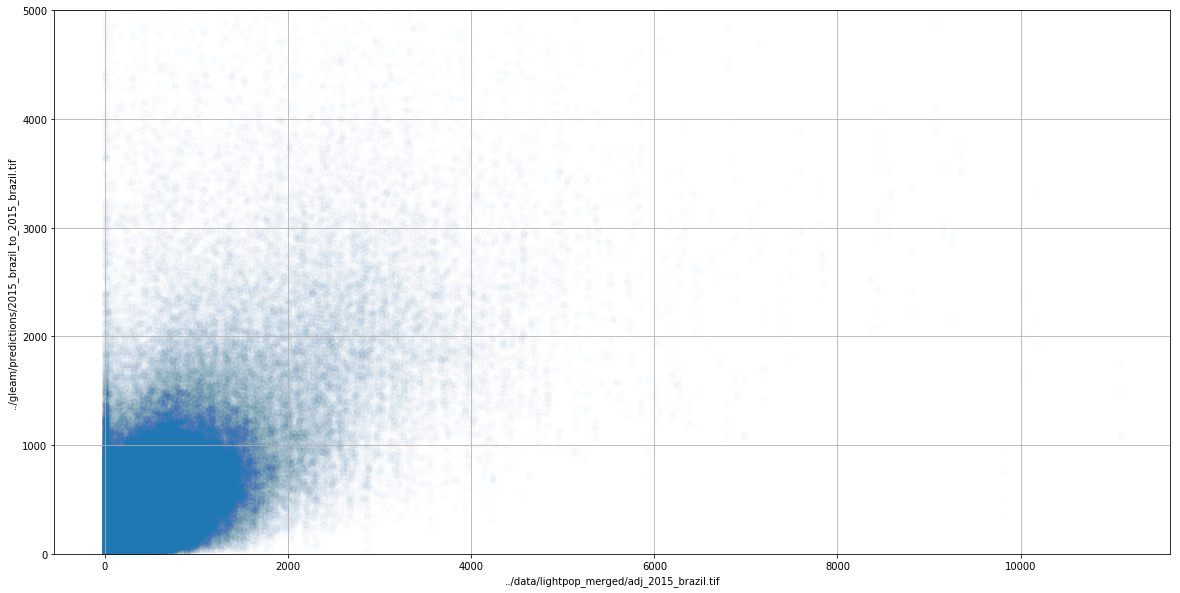

plots done !


In [11]:
## PARAMETERS ##
logscale = False # might need too much free memory if using a big raster

dataset1 = '../data/lightpop_merged/adj_2015_brazil.tif'
band1 = 2

dataset2 = '../gleam/predictions/2015_brazil_to_2015_brazil.tif'
band2 = 1
maxval = 5000  # max value for y axis to cut off outliers

source = '../data/lightpop_merged/adj_2015_brazil.tif'
oputput_path = "scatters/2015_brazil_vs_prediction.png"
################

valuesX = []
valuesY = []

raster1 = rasterio.open(dataset1)
raster2 = rasterio.open(dataset2)

valuesX = raster1.read(band1)
valuesY = raster2.read(band2)
    
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(1, 1, 1)
ax1.set_ylim(0, maxval)

if logscale:
    plt.xscale('log')
    plt.yscale('log')
ax1.scatter(valuesX, valuesY, alpha=0.01)
ax1.set(xlabel=dataset1, ylabel=dataset2)
ax1.grid()
fig.savefig(oputput_path)

valuesX, valuesY = None, None
raster.close()
plt.show()
plt.close(fig)

print('done !')

# Diff
This script computes the pixel-by-pixel difference between two rasters (dataset2 minus dataset1) and saves the result in a new raster (out). The input rasters must have the same boundaries.

In [5]:
## PARAMETERS ##
dataset1 = '../gleam/predictions/2015_brazil_to_2015_portugal.tif'
band1 = 1

dataset2 = '../data/lightpop_merged/adj_2015_portugal.tif'
band2 = 2

out = 'diffs/british_islands_act_vs_pred_2015_trained_on_usa.tif'
################

print('opening rasters')

raster1 = rasterio.open(dataset1)
raster2 = rasterio.open(dataset2)

print('generating raster')

raster3 = raster2.read(band2) - raster1.read(band1)

profile = raster1.profile
profile.update(count=1)

with rasterio.open(out, 'w', **profile) as dst:
    dst.write(raster3.astype(rasterio.float32), 1)
raster1.close()
raster2.close()
raster3 = None
print('done !')


opening rasters
generating raster
done !


# Statistics
This script computes the Pearson correlation coefficient between two rasters, as well as a few helpful statistics to compare a prediction with a validation dataset or another prediction, pixel by pixel.

The input rasters must have the same boundaries.

In [17]:
## PARAMETERS ##
dataset1 = '../data/lightpop_merged/adj_2015_british_islands.tif'
band1 = 2

dataset2 = '../gleam/predictions/2015_usa_to_2015_british_islands.tif'
band2 = 1

ignore_zeros = True  # use this to remove zeros, allows more accurate pixel-by-pixel mean error and Pearson correlation
################

print('opening rasters')

r1 = rasterio.open(dataset1)
raster1 = r1.read(band1).flatten()
r1.close()
r2 = rasterio.open(dataset2)
raster2 = r2.read(band2).flatten()
r2.close()

if ignore_zeros:
    mask = raster1 != 0
    raster1, raster2 = raster1[mask], raster2[mask]
        

sum1 = np.sum(raster1)
sum2 = np.sum(raster2)

print('Pearson correlation : ' + str(np.corrcoef(raster1.flatten(), raster2.flatten())[0, 1]))
print('Sum of values : ' + str(sum1) + ', ' + str(sum2))
print('Sum increase : ' + str(sum2 - sum1) + ' (' + str(100*(sum2 - sum1)/sum1) + ' %)')
print('Mean absolute error (by pixel) : ' + str(mean_absolute_error(raster1.flatten(), raster2.flatten())))

raster1 = None
raster2 = None

print('done !')

opening rasters
Pearson correlation : 0.5955144725675939
Sum of values : 68446010.0, 35654788.0
Sum increase : -32791220.0 (-47.908155578627756 %)
Mean absolute error (by pixel) : 21.019371
done !
